# Di-Higgs regressor final training

## Import

### Import modules

In [31]:
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K
from __future__ import division ,print_function
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import seaborn as sns
import sys
sys.path.append('../../../../modules')
from MPPlot import *
from Processors import *
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
sys.path.append('../')
from Regression_Application import *


### Import data
Here just looking at mu tau_h b b final-state

In [32]:
mode = "mu_tau_b_b"
loc = './../../../../../data/'
SignalData = []
BackgroundData = []

energies = [320]
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

signalData = pandas.read_csv(loc + "signal.csv")
backgroundData = pandas.read_csv(loc + "background.csv")

# Drop columns without header
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)

 #Load data from CSV files
"""for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['mass'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(loc + back + "_TuneCUETP8M1_13TeV.csv")
    backgroundData['mass'] = 0
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))"""

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset
def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X


data = cleanData(data)


Samples contains 71614 signal events and 103690 background events
175304 events in total
Index([u't_0_pT', u't_0_eta', u't_0_phi', u't_0_mass', u't_1_pT', u't_1_eta',
       u't_1_phi', u't_1_mass', u'b_0_pT', u'b_0_eta', u'b_0_phi', u'b_0_mass',
       u'b_1_pT', u'b_1_eta', u'b_1_phi', u'b_1_mass', u'mPT_pT', u'mPT_phi',
       u'h_tt_pT', u'h_tt_eta', u'h_tt_phi', u'h_tt_mass', u'h_bb_pT',
       u'h_bb_eta', u'h_bb_phi', u'h_bb_mass', u'diH_pT', u'diH_eta',
       u'diH_phi', u'diH_mass', u'hT', u'sT', u'centrality', u'eVis', u'nJets',
       u'nBJets', u'nTauJets', u'minJetPT', u'meanJetPT', u'maxJetPT',
       u'minJetMass', u'meanJetMass', u'maxJetMass', u'minJetEta',
       u'meanJetEta', u'maxJetEta', u'nPhotons', u'sphericityA',
       u'spherocityA', u'aplanarityA', u'aplanorityA', u'upsilonA', u'dShapeA',
       u'sphericityP', u'spherocityP', u'aplanarityP', u'aplanorityP',
       u'upsilonP', u'dShapeP', u'gen_t_0_pT', u'gen_t_0_eta', u'gen_t_0_phi',
       u'gen_t_0_E', 

## Configure data

### Create development and validation samples

In [33]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum
 

moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

In [34]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


49124 events for training, 126180 events for validation


### Apply regressors

In [35]:
bRegressor = BPairRegressor(data, "../bRegression/weights/NN_B_Regressor_App_" + mode + "_" , mode)
bRegressor.evalResponse()
bRegressor.getExtraVariables()
bRegressor.refineDiHiggsVector()

10 components found in ensemble


In [36]:
tauRegressor = TauPairRegressor(data, "../tauRegression/weights/NN_Tau_Regressor_App_" + mode + "_" , mode)
tauRegressor.evalResponse()
tauRegressor.getExtraVariables()
tauRegressor.refineDiHiggsVector()

10 components found in ensemble


In [37]:
hhMomRegressor = HHMomRegressor(data, "../hhMomRegression/weights/NN_HH_Mom_Regressor_App_" + mode + "_" , mode)
hhMomRegressor.evalResponse()
hhMomRegressor.getExtraVariables()

10 components found in ensemble


../Regression_Application.py:118: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  self.data[prefix + '|p|'] = np.sqrt(np.square(self.data.ix[:, prefix + 'px'])+np.square(self.data.ix[:, prefix + 'py'])+np.square(self.data.ix[:, prefix + 'pz']))
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.o

### Specify variables

In [38]:
data.rename(columns={'weight': 'gen_weight'}, inplace=True)
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]
other = [var for var in trainFeatures for x in [ 'csv', 'diH_kinFit_prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]

In [39]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
regFeatures = [var for var in trainFeatures if (str.startswith(var, "reg"))]
regBFeatures = [var for var in trainFeatures if (str.startswith(var, "regB_"))]
regTauFeatures = [var for var in trainFeatures if (str.startswith(var, "regTau_"))]
regHHMomFeatures = [var for var in trainFeatures if (str.startswith(var, "regHH_"))]
regBDiHiggs = [var for var in regBFeatures if (str.startswith(var, "regB_diH_"))]
regTauDiHiggs = [var for var in regTauFeatures if (str.startswith(var, "regTau_diH_"))]
diHiggsFeatures = [var for var in trainFeatures if (str.startswith(var, "diH_"))]
regBasis = [var[var.find("_")+1:] for var in regFeatures]
massFeatures = [var for var in trainFeatures if "_mass" in var]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in globalFeatures + shapeFeatures + pTEtaPhi + hlFeatures + recoFeatures]
reducedFSFeatures = [var for var in fsFeatures if var not in regBasis]
reducedRecoFeatures = [var for var in recoFeatures if var not in regBasis]

In [40]:
set0 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + regBFeatures + regTauFeatures + regHHMomFeatures] + ['hl_mT']
set1 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regHHMomFeatures] + ['hl_mT']
set2 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regTauDiHiggs] + ['hl_mT'] + ['regTau_diH_mass']

## Specify options

In [41]:
regTrainFeatures = set2
regModel = 'model1'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_diH_mass']
print ("\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures])
print ("\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures])


Training on 47 features: ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_1_mass', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_0_|p|', 'regTau_t_0_E', 'regTau_t_1_|p|', 'regTau_t_1_E', 'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_E', 'regTau_h_tt_|p|', 'regTau_h_tt_mass', 'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_|p|', 'regHH_diH_E', 'hl_mT', 'regTau_diH_mass']

Regressing to 1 features: ['gen_diH_mass']


In [42]:
devData = data.loc[sig_devIndeces].copy()
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)
print ("{0} events for training, {1} events for validation".format(len(devData), len(valData)))

49124 events for training, 126180 events for validation


## Save/load

In [43]:
name = "weights/NN_HH_Regressor_App_" + mode + "_" 
print (name)

weights/NN_HH_Regressor_App_mu_tau_b_b_


### Load

In [44]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    outputPipe = pickle.load(fin)

## Define regressor

## Evaluation

### Calculate pull

In [45]:
def getResponse(pred, act):
    pull = pred[:,0]-act
    return (pull.mean(), pull.std())

### Preprocess data

In [46]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []
if normOut:
    stepsOut.append(('normOut', StandardScaler()))
else:
    stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)

In [47]:
X_reg = inputPipe.fit_transform(devData[regTrainFeatures].values.astype(theano.config.floatX))
y_reg = outputPipe.fit_transform(devData[regTargetFeatures].values.astype(theano.config.floatX))

### Train regressors
Train nSplit times to find best convergence

In [48]:
trainingData = (None, None)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(trainingData[0], trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [49]:
trainParams = {'epochs' : 10000, 'batch_size' : 64, 'verbose' : 0}

## Construct ensemble

In [50]:
results = None
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [51]:
def loadModel(cycle, location='train_weights/train_'):
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [52]:
def getWeights(value, met):
    return 1/value

In [53]:
ensemble = []
weights = []
print ("Choosing ensemble by", ensembleMode)
if ensembleMode == 'mix':
    for met in results[0]:
        print( "Choosing best for metric", met)
        cycle = np.argmin([result[met] for result in results])
        print (met, "Model", "is", cycle, "with", met, "=", results[cycle][met])
        ensemble.append(loadModel(cycle))
        weights.append(1)
else:
    dtype = [('cycle', int), ('result', float)]
    values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], dtype=dtype),
                     order=['result'])
    for i in range(min([ensembleSize, len(results)])):
        ensemble.append(loadModel(values[i]['cycle']))
        weights.append(getWeights(values[i]['result'], ensembleMode))
        print ("Model", i, "is", values[i]['cycle'], "with", ensembleMode, "=", values[i]['result'])
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by loss
Model 0 is 3 with loss = 0.0504867450995
Model 1 is 7 with loss = 0.0508778875661
Model 2 is 9 with loss = 0.0525088933658
Model 3 is 1 with loss = 0.0546049543256
Model 4 is 8 with loss = 0.0560618636712
Model 5 is 0 with loss = 0.062969781629
Model 6 is 5 with loss = 0.0634700336681
Model 7 is 6 with loss = 0.0641297486826
Model 8 is 2 with loss = 0.0642036275403
Model 9 is 4 with loss = 0.0657546144292


## Response of ensemble on development data

###  Preprocess data

In [54]:
X_dev = inputPipe.transform(devData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [55]:
pred = np.zeros((len(devData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_dev, verbose=0)) 
devData['regHH_diH_mass'] = pandas.Series(pred[:,0], index=devData.index)

### Evaluate response

In [56]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures):
    devData.ix[:, 'loss_d'] += np.square(devData.ix[:, 'regHH_' + feature[4:]]-devData.ix[:, feature])
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(devData['regHH_diH_mass'].values-devData['gen_diH_mass'].values, len(devData), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
print ('Ensemble on dev data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(devData.ix[:, 'loss_d'])/len(regTargetFeatures), meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))

Ensemble on dev data:
 Loss = 17299.9470605, Mean = -5.20926321014 +- 0.0576527651502, sigma = 131.488921811 +- 0.0609702188348


/home/goncalo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#depr

## Response of ensemble on validation data

###  Preprocess data

In [57]:
X_val = inputPipe.transform(valData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [58]:
pred = np.zeros((len(valData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_val, verbose=0)) 
valData['regHH_diH_mass'] = pandas.Series(pred[:,0], index=valData.index)

### Evaluate response

In [59]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures):
    valData.ix[sig, 'loss_v'] += np.square(valData.ix[sig, 'regHH_' + feature[4:]]-valData.ix[sig, feature])
meanBootReg = []
stvalBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['regHH_diH_mass'].values-valData[sig]['gen_diH_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stvalBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stvalReg = (np.mean(stvalBootReg), np.std(stvalBootReg)/math.sqrt(len(stvalBootReg)))
print ('Ensemble on val data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(valData.ix[sig, 'loss_v'])/len(regTargetFeatures), meanReg[0], meanReg[1], stvalReg[0], stvalReg[1]))

/home/goncalo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#depr

Ensemble on val data:
 Loss = 16619.474456, Mean = -4.50049720272 +- 0.112643157567, sigma = 128.963640086 +- 0.104402952677


/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]


### Two-sample Kolmogorov–Smirnov test

In [60]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['regHH_' + feature[4:]].values)
    print ("K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1]))


gen_diH_mass
K-S test result 0.0645, p-value of 0.0000


### Di-Higgs mass distribution

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


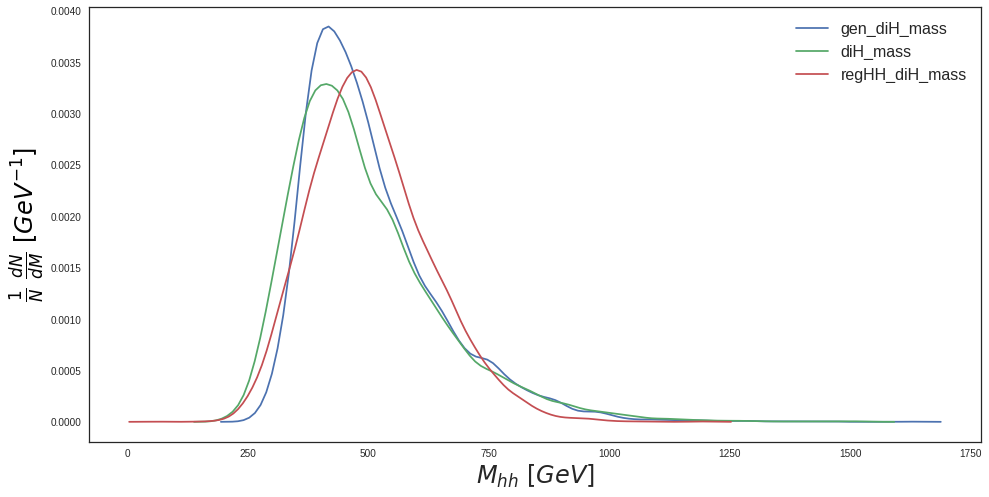

In [86]:
plt.figure(figsize=(16, 8))

sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'])

sns.kdeplot(data=valData.loc[sig, 'diH_mass'])

sns.kdeplot(data=valData.ix[sig, 'regHH_diH_mass'])
plt.legend(fontsize=16)
plt.xlabel(r"$M_{hh}\ [GeV]$", fontsize=24)
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dM}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [62]:
xPlot = np.linspace(0, 1500, 1500)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[bkg, 'diH_mass'], 'x':xPlot, 'name':'bkg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[bkg, 'regHH_diH_mass'], 'x':xPlot, 'name':'bkg_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'diH_mass'], 'x':xPlot, 'name':'sig', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'regHH_diH_mass'], 'x':xPlot, 'name':'sig_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'gen_diH_mass'], 'x':xPlot, 'name':'gen', 'kde':1, 'mean':1, 'std':1}])

In [63]:
meanReco = (np.mean(plots['sig' + '_mean']),
            np.std(plots['sig' + '_mean'])/math.sqrt(len(plots['sig' + '_mean'])))
stdReco = (np.mean(plots['sig' + '_std']),
             np.std(plots['sig' + '_std'])/math.sqrt(len(plots['sig' + '_std'])))
meanReg = (np.mean(plots['sig_reg' + '_mean']),
            np.std(plots['sig_reg' + '_mean'])/math.sqrt(len(plots['sig_reg' + '_mean'])))
stdReg = (np.mean(plots['sig_reg' + '_std']),
             np.std(plots['sig_reg' + '_std'])/math.sqrt(len(plots['sig_reg' + '_std'])))
meanGen = (np.mean(plots['gen' + '_mean']),
            np.std(plots['gen' + '_mean'])/math.sqrt(len(plots['gen' + '_mean'])))
stdGen = (np.mean(plots['gen' + '_std']),
             np.std(plots['gen' + '_std'])/math.sqrt(len(plots['gen' + '_std'])))

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


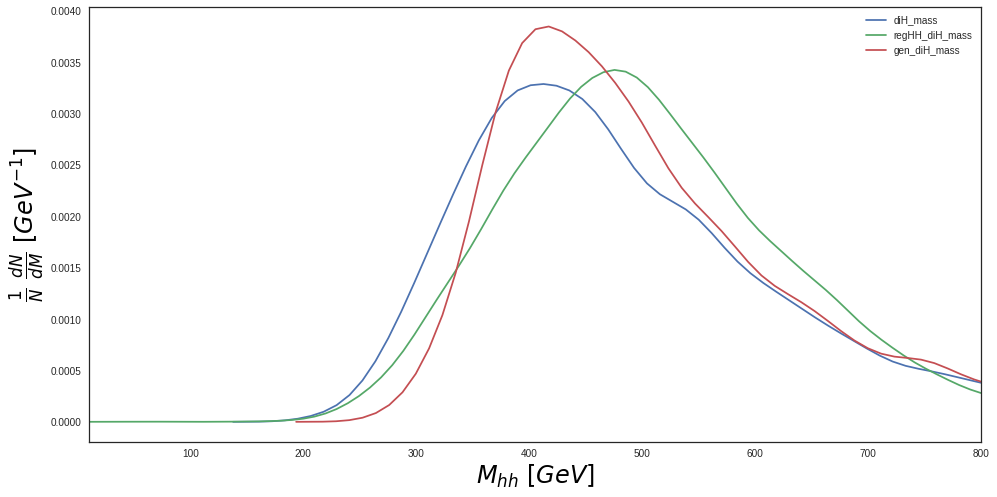

In [78]:
plt.figure(figsize=(16, 8))
#sns.kdeplot(data=valData.loc[bkg, 'diH_mass'])
#sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'])
plt.xlabel(r"$M_{hh}\ [GeV]$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dM}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.xlim(10,800)
plt.show()


In [65]:
pullRegHH = valData[sig]['regHH_diH_mass'].values-valData[sig]['gen_diH_mass'].values
pullReco = valData[sig]['diH_mass'].values-valData[sig]['gen_diH_mass'].values
xPlot = np.linspace(-300, 300, 600)[:, np.newaxis]
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice(pullReco, len(pullReco), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
bootRegHH = []
meanBootRegHH = []
stdevBootRegHH = []
for i in range(100):
    points = np.random.choice(pullRegHH, len(pullRegHH), replace=True)
    meanBootRegHH.append(points.mean())
    stdevBootRegHH.append(points.std())
meanRegHH = (np.mean(meanBootRegHH), np.std(meanBootRegHH)/math.sqrt(len(meanBootRegHH)))
stdevRegHH = (np.mean(stdevBootRegHH), np.std(stdevBootRegHH)/math.sqrt(len(stdevBootRegHH)))
print ('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHH[0], meanRegHH[1], stdevRegHH[0], stdevRegHH[1]))
print ('Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

Regressed Signal, Mean = -4.32372631207 +- 0.119341682145, sigma = 128.919756272 +- 0.0952633870597
Reconstructed Signal,  Mean = -14.0690640453 +- 0.0824170301487, sigma = 87.2246787436 +- 0.149207008415


In [66]:
xPlot = np.linspace(-300, 300, 600)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sig, 'diH_mass']-valData.ix[sig,'gen_diH_mass'], 'x':xPlot, 'name':'reco', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sig, 'regHH_diH_mass']-valData.ix[sig,'gen_diH_mass'], 'x':xPlot, 'name':'reg', 'kde':1, 'mean':1, 'std':1}])

/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]


In [67]:
meanReco = (np.mean(plots['reco' + '_mean']),
            np.std(plots['reco' + '_mean'])/math.sqrt(len(plots['reco' + '_mean'])))
stdReco = (np.mean(plots['reco' + '_std']),
             np.std(plots['reco' + '_std'])/math.sqrt(len(plots['reco' + '_std'])))
meanReg = (np.mean(plots['reg' + '_mean']),
            np.std(plots['reg' + '_mean'])/math.sqrt(len(plots['reg' + '_mean'])))
stdReg = (np.mean(plots['reg' + '_std']),
             np.std(plots['reg' + '_std'])/math.sqrt(len(plots['reg' + '_std'])))

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


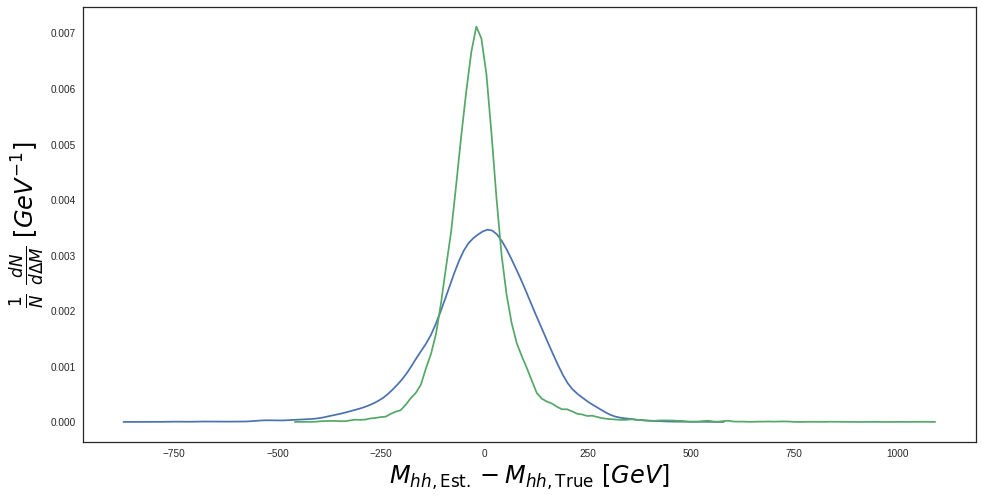

In [68]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=pullRegHH)
sns.kdeplot(data=pullReco)
plt.xlabel(r"$M_{hh,\mathrm{Est.}}-M_{hh,\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.yticks
plt.show()

### ROC Curve

In [69]:
print ('Reg:', roc_auc_score(valData.ix[sig|bkg, 'gen_target'], valData.ix[sig|bkg, 'regHH_diH_mass']))
print ('Reco:', roc_auc_score(valData.ix[sig|bkg, 'gen_target'], valData.ix[sig|bkg, 'diH_mass']))

Reg: 0.673896391071
Reco: 0.564390236728


/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


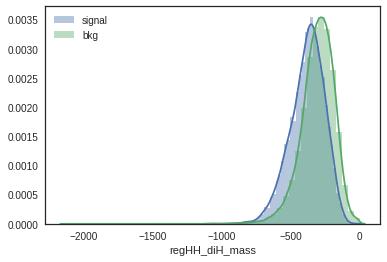

In [70]:
sns.distplot(-np.abs(125-valData.ix[sig, 'regHH_diH_mass']), label='signal')
sns.distplot(-np.abs(125-valData.ix[bkg, 'regHH_diH_mass']), label='bkg')
plt.legend()

## Classifiers response

### Train

In [71]:
classFeatures = ['b_0_mass',
                 'b_1_mass',
                 't_0_mass',
                 't_1_mass',
                 'mPT_px', 'mPT_py',
                 'diH_px', 'diH_py', 'diH_pz', 'diH_E', 'diH_|p|',
                 'hl_mT']

In [72]:
recoFeatures = ['diH_mass']
recoFeatures += ['b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
                 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E',
                 't_0_px', 't_0_py', 't_0_pz', 't_0_E', 't_0_|p|',
                 't_1_px', 't_1_py', 't_1_pz', 't_1_E', 't_1_|p|',
                 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E',
                 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_mass', 'h_tt_E', 'h_tt_|p|']
recoFeatures += classFeatures
print (len(recoFeatures), "Training features")
recoClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
recoClass.fit(valData[recoFeatures], valData['gen_target'].values.astype('int'))

44 Training features


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=-999.0, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [73]:
regFeatures = ['regHH_diH_mass']
regFeatures += ['regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_0_|p|', 'regB_b_0_E',
                'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_1_|p|', 'regB_b_1_E',
                'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_0_E', 'regTau_t_0_|p|',
                'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_1_E', 'regTau_t_1_|p|',
                'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_mass', 'regTau_h_tt_E', 'regTau_h_tt_|p|',
                'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_|p|', 'regB_h_bb_E']
regFeatures += classFeatures
regClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
regClass.fit(valData[regFeatures], valData['gen_target'].values.astype('int'))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=-999.0, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Test

In [74]:
recoPred = recoClass.predict_proba(valData[recoFeatures])[:,1]

In [75]:
regPred = regClass.predict_proba(valData[regFeatures])[:,1]

In [76]:
recoAUC = roc_auc_score(valData['gen_target'].values, recoPred)
regAUC = roc_auc_score(valData['gen_target'].values, regPred)

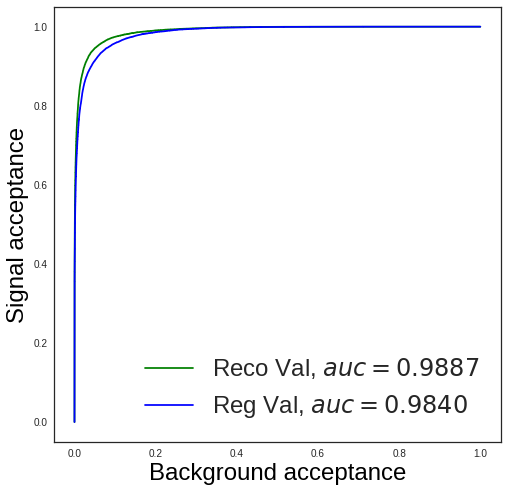

In [77]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(valData['gen_target'].values, recoPred)[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC), color='g')
plt.plot(*roc_curve(valData['gen_target'].values, regPred)[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC), color='b')
#plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=24)
plt.show()

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


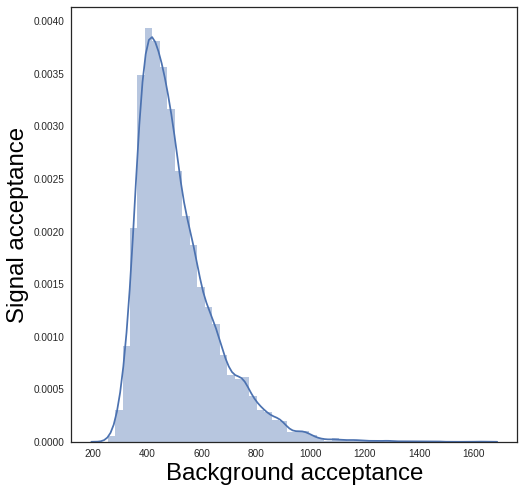

12281     0.0
12282     0.0
12283     0.0
12284     0.0
12285     0.0
12286     0.0
12287     0.0
12288     0.0
12289     0.0
12290     0.0
12291     0.0
12292     0.0
12293     0.0
12294     0.0
12295     0.0
12296     0.0
12297     0.0
12298     0.0
12299     0.0
12300     0.0
12301     0.0
12302     0.0
12303     0.0
12304     0.0
12305     0.0
12306     0.0
12307     0.0
12308     0.0
12309     0.0
12310     0.0
         ... 
115941    0.0
115942    0.0
115943    0.0
115944    0.0
115945    0.0
115946    0.0
115947    0.0
115948    0.0
115949    0.0
115950    0.0
115951    0.0
115952    0.0
115953    0.0
115954    0.0
115955    0.0
115956    0.0
115957    0.0
115958    0.0
115959    0.0
115960    0.0
115961    0.0
115962    0.0
115963    0.0
115964    0.0
115965    0.0
115966    0.0
115967    0.0
115968    0.0
115969    0.0
115970    0.0
Name: gen_diH_mass, Length: 103690, dtype: float64


In [85]:
plt.figure(figsize=[8, 8])
sns.distplot(valData[sig]['gen_diH_mass'])
#sns.distplot(valData[bkg]['gen_diH_mass'])
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=24)
plt.show()
